# Value At Risk (VAR) Model
https://ocw.mit.edu/courses/mathematics/18-s096-topics-in-mathematics-with-applications-in-finance-fall-2013/lecture-notes/MIT18_S096F13_lecnote7.pdf

In [1]:
%load_ext nb_black

import json
from statistics import mean
from scipy.stats import pearsonr
import math


def get_usd_timeseries(file):
    f = open(file)
    data = json.load(f)
    f.close()
    return [price for (timestamp, price) in data["prices"]]


def get_volume_timeseries(file):
    f = open(file)
    data = json.load(f)
    f.close()
    prices = get_usd_timeseries(file)
    volumes = []
    for i in range(len(data["total_volumes"])):
        (timestamp, usd_volume) = data["total_volumes"][i]
        volumes.append(usd_volume / prices[i])
    return volumes


def determine_price_between_assets(asset_1_prices, asset_2_prices):
    return [
        asset_1_price / asset_2_price
        for (asset_1_price, asset_2_price) in zip(asset_1_prices, asset_2_prices)
    ]


def prices_to_returns(prices):
    return [(prices[i] / prices[i - 1] - 1) for i in range(1, len(prices))]


kusama_to_usd_hourly = get_usd_timeseries("kusama_to_usd_hourly_Mar_Jun.json")
bitcoin_to_usd_hourly = get_usd_timeseries("bitcoin_to_usd_hourly_Mar_Jun.json")
ksm_to_btc_hourly = determine_price_between_assets(
    kusama_to_usd_hourly, bitcoin_to_usd_hourly
)
ksm_to_btc_returns_hourly = prices_to_returns(ksm_to_btc_hourly)

kusama_to_usd_daily = get_usd_timeseries("kusama_to_usd_daily_2021.json")
ksm_usd_returns_daily = prices_to_returns(kusama_to_usd_daily)

bitcoin_to_usd_daily = get_usd_timeseries("bitcoin_to_usd_daily_2021.json")
btc_usd_returns_daily = prices_to_returns(bitcoin_to_usd_daily)

ksm_to_btc_daily = determine_price_between_assets(
    kusama_to_usd_daily, bitcoin_to_usd_daily
)
ksm_to_btc_returns_daily = prices_to_returns(ksm_to_btc_daily)

observed_ksm_btc_corr, _ = pearsonr(ksm_usd_returns_daily, btc_usd_returns_daily)

ksm_daily_volumes = get_volume_timeseries("kusama_to_usd_daily_2021.json")
btc_daily_volumes = get_volume_timeseries("bitcoin_to_usd_daily_2021.json")

ksm_min_daily_liquidity = min(ksm_daily_volumes)
btc_min_daily_liquidity = min(btc_daily_volumes)

print("Correlation is: " + str(observed_ksm_btc_corr))

Correlation is: 0.5835797683497566


<IPython.core.display.Javascript object>

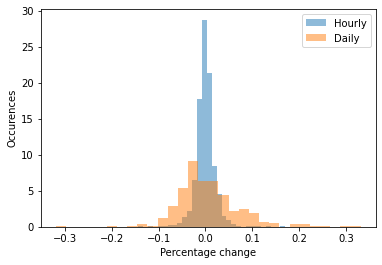

<IPython.core.display.Javascript object>

In [2]:
import matplotlib.pyplot as plt
import numpy as np


def plot_returns(returns, data_label):
    plt.hist(
        returns, density=True, bins=30, alpha=0.5, label=data_label
    )  # density=False would make counts
    plt.ylabel("Occurences")
    plt.xlabel("Percentage change")
    plt.legend(loc="upper right")


plot_returns(ksm_to_btc_returns_hourly, "Hourly")
plot_returns(ksm_to_btc_returns_daily, "Daily")

In [12]:
import statistics
confidence_99 = 2.33
confidence_95 = 1.64
LIQUIDATION_THRESHOLD = 1.6
# Compute stddev using the daily returns, as these have higher volatility
# VaR occasionally underestimates the number of large market moves.
# Could consider a higher confidence interval to be on the safe side
std_dev = statistics.pstdev(ksm_to_btc_returns_daily)
expected_loss_percentage_99 = confidence_99 * std_dev
expected_loss_percentage_95 = confidence_95 * std_dev
print("99% confidence interval max price drop (%): " + str(expected_loss_percentage_99 * 100))
required_collateralization_99 = LIQUIDATION_THRESHOLD / (1 - expected_loss_percentage_99)
required_collateralization_95 = LIQUIDATION_THRESHOLD / (1 - expected_loss_percentage_95)
print("Liquidation threshold assumption: " + str(LIQUIDATION_THRESHOLD))
print("Required collateralization (99% confidence interval): " + str(required_collateralization_99))
print("Required collateralization (95% confidence interval): " + str(required_collateralization_95))


99% confidence interval max price drop (%): 16.89542491711588
Liquidation threshold assumption: 1.6
Required collateralization (99% confidence interval): 1.9252850982081846
Required collateralization (95% confidence interval): 1.8159543590713416


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Monte Carlo Simulation
https://arxiv.org/pdf/2002.08099.pdf

Independently simulates the prices of KSM/USD and BTC/USD.

Selects the worst KSM/USD price trajectory, then picks the BTC/USD price trajectory that has the closest pearson correlation to the one in the real data sample.

All vaults considered a single entity, but they are separated from the liquidation vault. When vaults become undercollateralized, liquidators acquire as much liquidity as possible within the constraints, to arbitrage. The assumed available liquidity for both KSM and BTC is the mean traded volumes. Both are required, because liquidators are assumed ot start up their own vault before liquidating.

In the current model, daily liquidity is assumed to be constant. 

In [4]:
# Kusama/USD daily (01/01/2021 - 09/09/2021): https://api.coingecko.com/api/v3/coins/kusama/market_chart/range?vs_currency=usd&from=1609459200&to=1631189591
# Bitcoin/USD daily (01/01/2021 - 09/09/2021): https://api.coingecko.com/api/v3/coins/bitcoin/market_chart/range?vs_currency=usd&from=1609459200&to=1631189591

# Kusama/USD hourly (26/03/2021 - 23/06/2021): https://api.coingecko.com/api/v3/coins/kusama/market_chart/range?vs_currency=usd&from=1616716800&to=1624406400
# Bitcoin/USD daily (26/03/2021 - 23/06/2021): https://api.coingecko.com/api/v3/coins/bitcoin/market_chart/range?vs_currency=usd&from=1616716800&to=1624406400

SIMULATED_SCENARIOS = 1000
PRICE_PATHS_PER_SIMULATION = 500
PREDICTED_DAYS = 100
# premium redeem is skipped
PREMIUM_REDEEM_BONUS = 0.05

<IPython.core.display.Javascript object>

In [5]:
# Monte Carlo price simulation (Geometric Brownian Motion)
# Reference article: https://towardsdatascience.com/simulating-stock-prices-in-python-using-geometric-brownian-motion-8dfd6e8c6b18
import pandas as pd


def stochastic_price_simulation(
    returns, initial_price, prediction_days, scenario_count
):
    So = initial_price
    dt = 1
    T = prediction_days
    N = T / dt
    t = np.arange(1, int(N) + 1)
    mu = np.mean(returns)
    sigma = np.std(returns)
    scen_size = scenario_count
    b = {str(scen): np.random.normal(0, 1, int(N)) for scen in range(1, scen_size + 1)}
    W = {str(scen): b[str(scen)].cumsum() for scen in range(1, scen_size + 1)}

    # Calculating drift and diffusion components
    drift = (mu - 0.5 * sigma ** 2) * t
    diffusion = {str(scen): sigma * W[str(scen)] for scen in range(1, scen_size + 1)}

    # Making the predictions
    S = np.array(
        [So * np.exp(drift + diffusion[str(scen)]) for scen in range(1, scen_size + 1)]
    )
    S = np.hstack(
        (np.array([[So] for scen in range(scen_size)]), S)
    )  # add So to the beginning series

    # Plotting the simulations
    #     plt.figure(figsize = (20,10))
    #     for i in range(scen_size):
    #         plt.title("Daily Volatility: " + str(sigma))
    #         plt.plot(S[i, :])
    #         plt.ylabel('Price')
    #         plt.xlabel('Prediction Days')
    #     plt.show()
    return S


def get_worst_price_trajectory(S):
    min_price = S[0, -1]
    index = 0
    for i in range(len(S)):
        if S[i, -1] < min_price:
            min_price = S[i, -1]
            index = i
    return S[index, :]


def get_trajectory_with_closest_correlation(S, base_trajectory, corr):
    picked_trajectory = S[0, :]
    index = 0
    closest_found_correlation, _ = pearsonr(base_trajectory, S[0, :])
    for i in range(len(S)):
        tmp_corr, _ = pearsonr(base_trajectory, S[i, :])
        if abs(tmp_corr - corr) < abs(closest_found_correlation - corr):
            closest_found_correlation = tmp_corr
            picked_trajectory = S[i, :]
            index = i
    return S[index, :], closest_found_correlation


def get_days_of_undercollateralization(
    worst_ksm_scenario_trajectory,
    correlated_btc_scenario_trajectory,
    ksm_min_daily_liquidity,
    btc_min_daily_liquidity,
    debt_ceiling_usd,
    secure_threshold,
    liquidation_threshold,
    daily_liquidity_decrease_ro,
):
    starting_ksm_price = worst_ksm_scenario_trajectory[0]
    starting_btc_price = correlated_btc_scenario_trajectory[0]
    vaults_issued = (debt_ceiling_usd / secure_threshold) / starting_btc_price
    vaults_ksm_collateral = debt_ceiling_usd / starting_ksm_price

    liquidation_vault_issued = 0
    liquidation_vault_ksm_collateral = 0
    current_ksm_btc_price = starting_ksm_price / starting_btc_price

    system_ksm_daily = []
    vault_ksm_daily = []
    liquidation_vault_ksm_daily = []
    daily_collateralization = []
    days_of_undercollateralization = 0
    available_liquidity = ksm_min_daily_liquidity
    for (ksm_usd, btc_usd) in zip(
        worst_ksm_scenario_trajectory, correlated_btc_scenario_trajectory
    ):
        current_ksm_btc_price = ksm_usd / btc_usd
        vault_required_ksm = vaults_issued / current_ksm_btc_price
        system_required_ksm = (
            vaults_issued + liquidation_vault_issued
        ) / current_ksm_btc_price
        system_ksm_daily.append(system_required_ksm)
        vault_ksm_daily.append(vaults_ksm_collateral)
        liquidation_vault_ksm_daily.append(liquidation_vault_ksm_collateral)
        system_collateralization = (
            vaults_ksm_collateral + liquidation_vault_ksm_collateral
        ) / system_required_ksm
        if (
            vaults_issued > 0
            and vaults_ksm_collateral / vault_required_ksm < liquidation_threshold
        ):
            # liquidate every vault
            liquidation_vault_issued = vaults_issued
            vaults_issued = 0
            liquidation_vault_ksm_collateral = vaults_ksm_collateral
            vaults_ksm_collateral = 0
        if liquidation_vault_issued > 0:
            # liquidity is reduced exponentially
            available_liquidity = available_liquidity * math.exp(
                -daily_liquidity_decrease_ro
            )
            # mint interbtc for the liquidation
            newly_minted_btc = min(
                min(btc_min_daily_liquidity, available_liquidity / secure_threshold),
                liquidation_vault_issued,
            )
            newly_added_collateral = (
                newly_minted_btc / current_ksm_btc_price
            ) * secure_threshold
            vaults_issued += newly_minted_btc
            vaults_ksm_collateral += newly_added_collateral

            # perform burn redeem
            burn_dot_payout = (
                liquidation_vault_ksm_collateral / liquidation_vault_issued
            ) * newly_minted_btc
            liquidation_vault_issued -= newly_minted_btc
            liquidation_vault_ksm_collateral = round(
                liquidation_vault_ksm_collateral - burn_dot_payout
            )
        else:
            available_liquidity = ksm_min_daily_liquidity
        daily_collateralization.append(system_collateralization)
        if system_collateralization < 1:
            days_of_undercollateralization += 1
    return (
        days_of_undercollateralization,
        daily_collateralization,
        liquidation_vault_ksm_daily,
    )


def get_worst_pair_of_ksm_and_btc_trajectories(
    scenarios_count,
    ksm_btc_corr,
    debt_ceiling_usd,
    secure_threshold,
    liquidation_threshold,
    daily_liquidity_decrease_ro,
):
    worst_btc_trajectory = []
    worst_ksm_trajectory = []
    most_days_of_undercollateralization = 0
    worst_daily_collateralization_trajectory = []
    worst_liquidation_vault_collateral_trajectory = []
    for i in range(scenarios_count):
        ksm_price_simulations = stochastic_price_simulation(
            ksm_usd_returns_daily,
            kusama_to_usd_daily[0],
            PREDICTED_DAYS,
            PRICE_PATHS_PER_SIMULATION,
        )
        worst_ksm_scenario_trajectory = get_worst_price_trajectory(
            ksm_price_simulations
        )
        btc_price_simulations = stochastic_price_simulation(
            btc_usd_returns_daily,
            bitcoin_to_usd_daily[0],
            PREDICTED_DAYS,
            PRICE_PATHS_PER_SIMULATION,
        )
        (
            correlated_btc_scenario_trajectory,
            closest_found_correlation,
        ) = get_trajectory_with_closest_correlation(
            btc_price_simulations, worst_ksm_scenario_trajectory, ksm_btc_corr
        )
        (
            days_of_undercollateralization,
            daily_collateralization,
            liquidation_vault_ksm_daily,
        ) = get_days_of_undercollateralization(
            worst_ksm_scenario_trajectory,
            correlated_btc_scenario_trajectory,
            ksm_min_daily_liquidity,
            btc_min_daily_liquidity,
            debt_ceiling_usd,
            secure_threshold,
            liquidation_threshold,
            daily_liquidity_decrease_ro,
        )
        if (
            days_of_undercollateralization > most_days_of_undercollateralization
            or most_days_of_undercollateralization == 0
        ):
            most_days_of_undercollateralization = days_of_undercollateralization
            worst_btc_trajectory = correlated_btc_scenario_trajectory
            worst_ksm_trajectory = worst_ksm_scenario_trajectory
            worst_daily_collateralization_trajectory = daily_collateralization
            worst_liquidation_vault_collateral_trajectory = liquidation_vault_ksm_daily
    return (
        worst_ksm_trajectory,
        worst_btc_trajectory,
        worst_daily_collateralization_trajectory,
        worst_liquidation_vault_collateral_trajectory,
        most_days_of_undercollateralization,
    )

<IPython.core.display.Javascript object>

In [6]:
%reload_ext nb_black


def plot_collateralization(
    subplot, liquidation_vault_ksm_daily, daily_collateralization, liquidation_threshold
):
    subplot.plot([l / 1000000000 for l in liquidation_vault_ksm_daily])
    subplot.plot(daily_collateralization)
    subplot.plot([liquidation_threshold] * len(daily_collateralization))
    subplot.plot([1.0] * len(daily_collateralization))
    subplot.legend(
        [
            "liquidation_vault_collateral",
            "collateralization",
            "liquidation threshold",
            "undercollateralization",
        ]
    )


def plot_prices(subplot, ksm_price_trajectory, btc_price_trajectory):
    subplot.plot([price * 1000 for price in ksm_price_trajectory])
    subplot.plot(btc_price_trajectory)
    subplot.legend(["ksm price (x1000)", "btc price"])


def simulate_and_plot(
    simulated_scenarios,
    observed_ksm_btc_corr,
    debt_ceiling_usd,
    secure_threshold,
    liquidation_threshold,
    daily_liquidity_decrease_ro,
):
    (
        ksm_price_trajectory,
        btc_price_trajectory,
        daily_collateralization,
        liquidation_vault_ksm_daily,
        days_of_undercollateralization,
    ) = get_worst_pair_of_ksm_and_btc_trajectories(
        simulated_scenarios,
        observed_ksm_btc_corr,
        debt_ceiling_usd,
        secure_threshold,
        liquidation_threshold,
        daily_liquidity_decrease_ro,
    )
    print("days of undercollateralization:" + str(days_of_undercollateralization))
    fig, axs = plt.subplots(2, figsize=(12, 10))
    plot_collateralization(
        axs[0],
        liquidation_vault_ksm_daily,
        daily_collateralization,
        liquidation_threshold,
    )
    plot_prices(axs[1], ksm_price_trajectory, btc_price_trajectory)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

days of undercollateralization:0


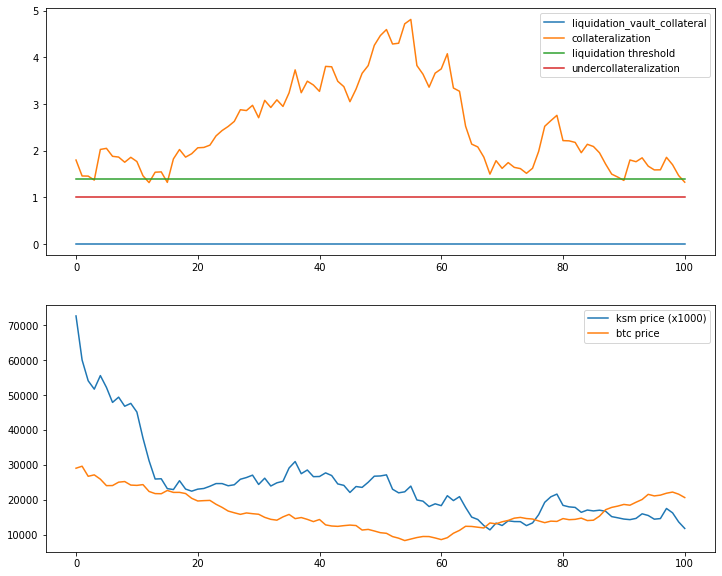

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
DEBT_CEILING_USD = 10_000_000_000
SECURE_THRESHOLD = 1.8
LIQUIDATION_THRESHOLD = 1.4
DAILY_LIQUIDITY_DECREASE_RO = 0.01
simulate_and_plot(
    SIMULATED_SCENARIOS,
    observed_ksm_btc_corr,
    DEBT_CEILING_USD,
    SECURE_THRESHOLD,
    LIQUIDATION_THRESHOLD,
    DAILY_LIQUIDITY_DECREASE_RO,
)

days of undercollateralization:0


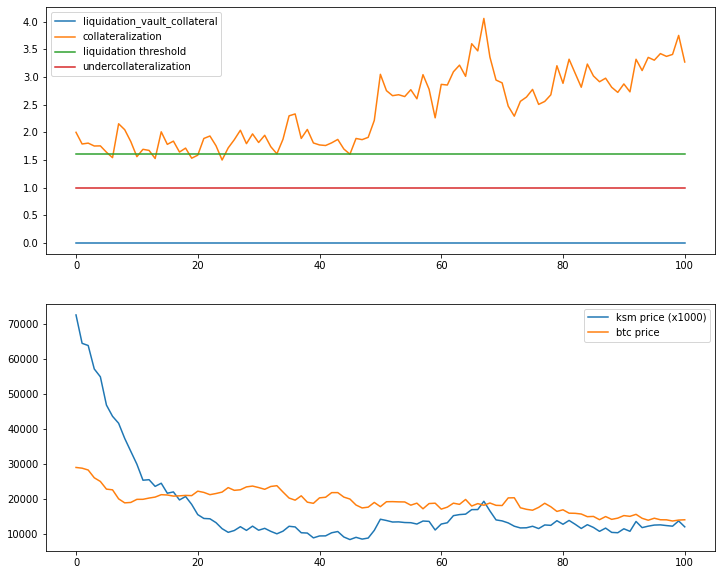

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
DEBT_CEILING_USD = 10_000_000_000
SECURE_THRESHOLD = 2.0
LIQUIDATION_THRESHOLD = 1.6
DAILY_LIQUIDITY_DECREASE_RO = 0.01
simulate_and_plot(
    SIMULATED_SCENARIOS,
    observed_ksm_btc_corr,
    DEBT_CEILING_USD,
    SECURE_THRESHOLD,
    LIQUIDATION_THRESHOLD,
    DAILY_LIQUIDITY_DECREASE_RO,
)

days of undercollateralization:0


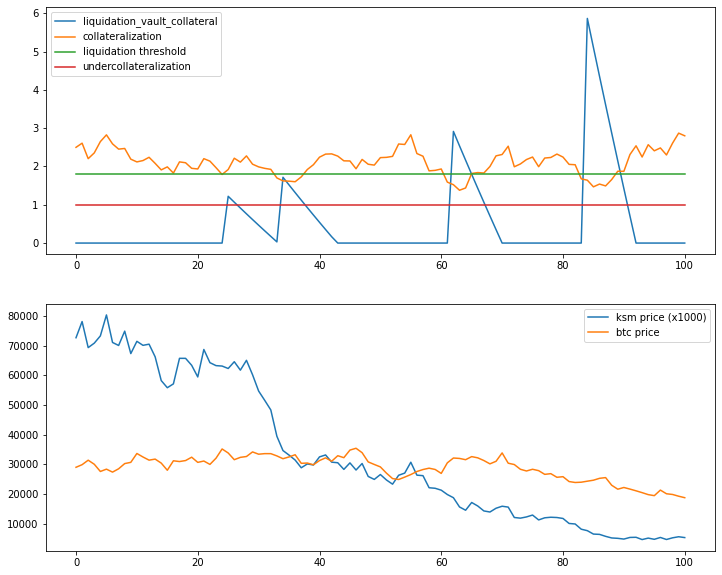

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
DEBT_CEILING_USD = 100_000_000_000
SECURE_THRESHOLD = 2.5
LIQUIDATION_THRESHOLD = 1.8
DAILY_LIQUIDITY_DECREASE_RO = 0.01
simulate_and_plot(
    SIMULATED_SCENARIOS,
    observed_ksm_btc_corr,
    DEBT_CEILING_USD,
    SECURE_THRESHOLD,
    LIQUIDATION_THRESHOLD,
    DAILY_LIQUIDITY_DECREASE_RO,
)